# Case: Advanced House Prices

Utilizando os conhecimentos adquiridos ao longo da graduação e dos meus primeiros meses na IBM, irei realizar uma versão extendida do clássico _case_ "House Prices".

O estudo de caso consiste em predizer o preço de casas em Sydney e Melbourne baseada em outras variáveis sobre a mesma, porém, diferentemente do caso clássico, este possui 79 variáveis (quase o dobro do banco de dados original) e outros 'problemas de vida real' inseridos no nosso _dataset_.

Este documento será disponibilizado em meu GitHub pessoal, juntamente com uma apresentação em Power Point que servirá de guia/resumo deste projeto e um dashboard interativo em Power BI.

## Inicialização

Chamando os bancos de dados ([disponível aqui](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)) e bibliotecas necessárias para a realização desse projeto:

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from itertools import chain, combinations
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import *

# Dados
dados = pd.read_csv("./train.csv")

Vamo realizar uma visualização superficial dos nossos dados para nos guiar no tratamento.

In [2]:
# Checando se há valores nulos (NA/NaN)
dados.isnull().values.any()

True

In [3]:
# Verificando em quais colunas existem valores nulos
dados.columns[dados.isna().any()].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [4]:
dados.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
dados.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460,1460,1201,1460,1460,1460,1460,1460,1452,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
mean,730.5,56.8973,70.05,10516.8,6.09932,5.57534,1971.27,1984.87,103.685,443.64,...,94.2445,46.6603,21.9541,3.40959,15.061,2.7589,43.489,6.32192,2007.82,180921
std,421.61,42.3006,24.2848,9981.26,1.383,1.1128,30.2029,20.6454,181.066,456.098,...,125.339,66.256,61.1191,29.3173,55.7574,40.1773,496.123,2.70363,1.3281,79442.5
min,1,20,21,1300,1,1,1872,1950,0,0,...,0,0,0,0,0,0,0,1,2006,34900
25%,365.75,20,59,7553.5,5,5,1954,1967,0,0,...,0,0,0,0,0,0,0,5,2007,129975
50%,730.5,50,69,9478.5,6,5,1973,1994,0,383.5,...,0,25,0,0,0,0,0,6,2008,163000
75%,1095.25,70,80,11601.5,7,6,2000,2004,166,712.25,...,168,68,0,0,0,0,0,8,2009,214000
max,1460,190,313,215245,10,9,2010,2010,1600,5644,...,857,547,552,508,480,738,15500,12,2010,755000


## Tratamento dos dados

Agora que temos uma noção superficial da disposição dos dados, podemos, juntamente com o documento "data_description.txt", fazer as substituições apropriadas para a modelagem e interpretação dos dados. 

### Remoção de variáveis de identificação

Vamos remover as variáveis que tem proprósito apenas de identificação, dado que ela não adiconará em mais nada para os estudos a seguir.

In [6]:
dados = dados.drop(["Id"], axis=1)

### Checagem e remoção de dados duplicados

Vamos checar e remover possíveis dados duplicados em nosso *dataframe* , visto que eles podem enviesar nossos modelos e análises

In [7]:
dados.duplicated().sum()

0

Não foi encontrado nenhum dado duplicado, podemos seguir com o tratamento dos dados.

### Substituição de valores ordinais

Vamos inicialmente substituir os dados ordinais qualitativos por uma escala likert numérica.

**Exemplo:**

GarageQual: Garage quality

- Ex (Excelent) -> 5
- Gd (Good) -> 4
- TA (Typical/Average) -> 3
- Fa (Fair) -> 2
- Po (Poor) -> 1
- NA (No Garage) -> 0

In [8]:
# selecionando colunas com valores como Execelent, Good....
likert1 = ['ExterQual', 
           'ExterCond', 
           'BsmtQual',
            'BsmtCond',
            'BsmtExposure',
            'HeatingQC',
            'KitchenQual',
            'FireplaceQu',
            'GarageCond',
            'PoolQC',
            'Fence']

# Substituindo valores

for i in likert1:
    dados[i] = dados[i].replace({"Ex": 5,
                                 "Gd": 4,
                                 "TA": 3,
                                 "Fa": 2,
                                 "Po": 1,
                                 'NA': 0,}, regex=True) 

# substituindo valores positivos/negativos

dados['CentralAir'] = dados['CentralAir'].replace({"Y" : 1,
                                                  "N" : 0})

# substituindo valores específicos


dados['BsmtExposure'] = dados['BsmtExposure'].replace({"Gd" : 4,
                                                       "Av" : 3,
                                                       "Mn" : 2,
                                                       "No" : 1,
                                                       "NA": 0})

porao = ['BsmtFinType1', 'BsmtFinType2']

for i in porao:
    dados[i] = dados[i].replace({"GLQ" : 6,
                                "ALQ" : 5,
                                "BLQ" : 4,
                                "Rec" : 3,
                                "LwQ": 2,
                                "Unf": 1,
                                'NA': 0})


### Tratamento de valores nulos

Anteriormente, fizemos uma checagem quanto a existencia de valores nulos em nossos dados e obtemos uma lista com todas as colunas onde um valor nulo se faz presente. Por se tratar de um número relativamente pequeno de colunas, podemos fazer uma investigação individual para saber qual o melhor procedimento em cada caso.

Nas colunas 'Alley', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2', 'MasVnrType', 'MasVnrArea', 'FireplaceQu','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','PoolQC','Fence' e 'MiscFeature'; A presença de um valor nulo representa a ausencia dessa característica. Em alguns casos isso pode significar, em contraste com a existencia dessa característica, uma 'pior qualidade' em alguns casos (como a ausencia de garagem ou piscina), em outros essa diferença pode não ser significativa (para um apartamento, por exemplo, verificar a presença de uma cerca é incoerente).

Então, para as colunas onde a presença da característica pode ser um diferencial, vamos substituir o valor nulo por 0 (Colunas relacionadas ao porão, garagem e piscina)

In [9]:
# Lista com nomes das colunas relacionadas a Garagem, porão e piscina

ListaGPP = ['BsmtQual',
      'BsmtCond',
      'BsmtExposure',
      'BsmtFinType1',
      'BsmtFinType2',
      'GarageType',
      'GarageYrBlt',
      'GarageFinish',
      'GarageQual',
      'GarageCond',
      'PoolQC']

# Substituindo os dados faltantes da lista por 0
dados[ListaGPP] = dados[ListaGPP].fillna(0)

REVISAR

Para estas colunas, é indiferente a existencia ou não dessas características na ordem das respostas. Podemos inclusive, ao invés de remover ou tratar os NA's, transformar essas variáveis em binárias, onde 1 representa uma resposta positiva para a existência da _feature_ e 0, o contrário. Para isso, façamos uma função:

In [10]:
# transformando todas as strings em "1's"

In [11]:
dados = dados.replace("Grvl", '1', regex=True)
dados = dados.replace("Pave", '1', regex=True)
dados = dados.replace("Elev", '1', regex=True)
dados = dados.replace("Gar2", '1', regex=True)
dados = dados.replace("Othr", '1', regex=True)
dados = dados.replace('Shed', '1', regex=True)
dados = dados.replace("TenC", '1', regex=True)

In [12]:
# Transformando dados faltantes em 0's
dados["MiscFeature"].fillna(0, inplace=True)
dados["FireplaceQu"].fillna(0, inplace=True)
dados["Alley"].fillna(0, inplace=True)

Passando agora para as demais colunas onde o valor ausente pode ter sido um erro, uma real falta desses dados ou até mesmo algo irrelevante. Dentre as colunas, o que mais me chamou a atenção foi a presença de um NA em "Eletrical", dado que se trata de uma coluna que descreve o tipo de sistema eletrico instalado na casa. Vamos verificar o número de valores ausentes nessa coluna e caso seja ínfimo, vamos excluir a linha em que eles estão presentes

In [13]:
# Verificando número de valores nulos em "eletrical"
dados['Electrical'].isna().sum()

1

In [14]:
# Existe apenas uma linha com a falta desse dado, vamos exclui-la para evitar possíveis complicações futuras

dados.drop(dados[dados['Electrical'].isna() == True].index, inplace=True)

No caso do "LotFrontage", podemos também substituir por 0, dado que a não existencia dele pode implicar numa distancia igual a zero.

In [15]:
dados["LotFrontage"] = dados["LotFrontage"].fillna(0)

Assim como no caso da coluna "Eletrical", vamos verificar o número de dados faltantes na coluna "MasVnrType", e excluir caso o número de ocorrencias seja suficientemente pequeno

In [16]:
dados["MasVnrType"].isna().sum()

8

In [17]:
# Podemos considerar que o número de dados faltantes é pequeno comparado ao tamanho do banco de dados
dados.drop(dados[dados['MasVnrType'].isna() == True].index, inplace=True)

Para o caso da coluna "Fence", como ja foi discutido anteriormente, é um tanto delicado dizer a sua influência no banco dados e os impactos de realizar transformações para suprir a falta de seus dados visto que não vou ter a oportunidade de discutir sobre com um *Stakeholder* ou especialista. Acredito que o melhor a se fazer nessa situação é excluir a coluna inteira

In [18]:
dados = dados.drop(["Fence"], axis=1)

### Substituição de valores binários

No dataframe presente, temos também a presença de valores binários no formato de *string*. Vamos substituir estes valores para um formato numérico.

In [19]:
dados['CentralAir']= dados['CentralAir'].replace("Y", '1', regex=True)
dados['CentralAir']= dados['CentralAir'].replace("N", '0', regex=True)

## Análise Exploratória de Dados

A análise a seguir será feita em duas partes para contemplar a maior parte do conhecimento adiquirido possível durante o meu período como IBMista, sendo uma parte feita neste relatório e outra em um *Dashboard* interativo realizado no Power BI.

Cono temos uma quantidade massiva de varíaveis, é quase que ímpossível realizar uma análise minuciosa de todas elas. Vamos então estudar um pouco acerca da nossa variável resposta e, a partir dela, selecionar quais variáveis devemos examinar mais detalhadamente.

### Análise da variável resposta 

In [20]:
dados['SalePrice'].describe().round()

count      1451.0
mean     180624.0
std       79312.0
min       34900.0
25%      129900.0
50%      162500.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

Dentre essa análise descritiva, podemos tirar algumas conclusões superficiais:

- Podemos observar uma discrepância considerável entre o valor que representa o 3º Quartil e o valor máximo, o que pode indicar a presença de *outliers* 
- O alto valor do desvio padrão e da amplitude entre o valor máximo e mínimo indicam uma curva leptocurtica.


Vamos observar graficamente a distribuição desses dados por meio de um boxplot

<AxesSubplot:>

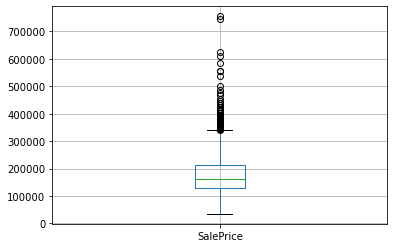

In [21]:
dados.boxplot(['SalePrice'])

Como foi pressuposto, existe um número excessivo de *outliers* em nossa variável resposta. Vamos verificar quais variáveis tem maior correlação com a variável resposta e assim seleciona-las para um estudo individual. 

Observando a distribuição da variável resposta de outra forma:

C:\Users\013756631\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

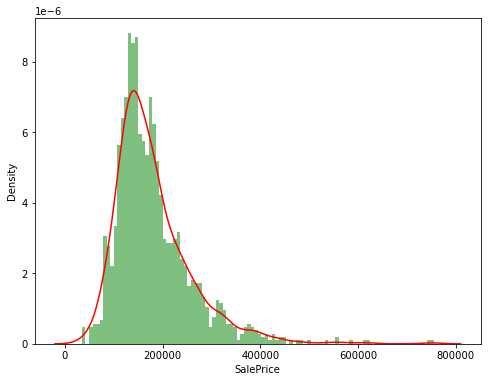

In [22]:
plt.figure(figsize=(8, 6))
sns.distplot(dados['SalePrice'], 
             bins=100, 
             hist_kws={'alpha': 0.5,
                       'color': 'g'},
             kde_kws={"color": "red"})

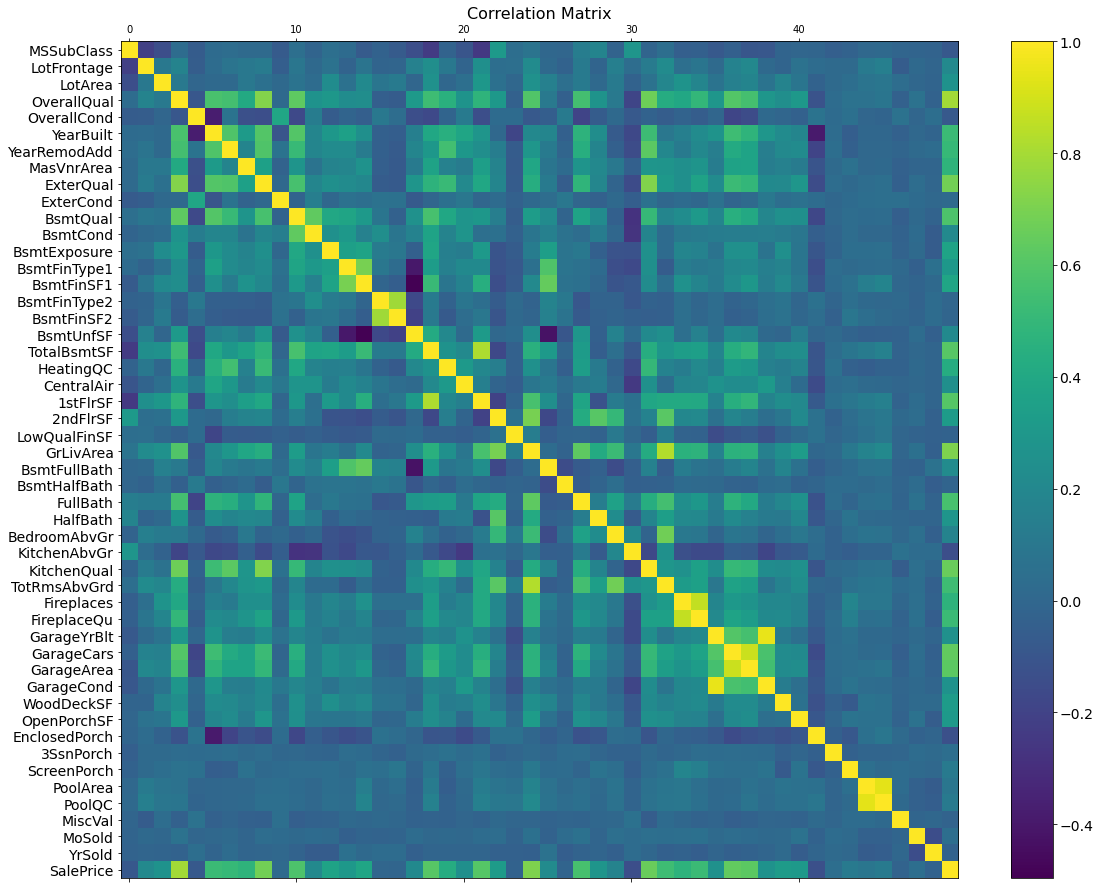

In [23]:
# Heatmap das variáveis numéricas

f = plt.figure(figsize=(19, 15))
plt.matshow(dados.corr(), fignum=f.number)
plt.yticks(range(dados.select_dtypes(['number']).shape[1]), dados.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

É relativamente complicado interpretar todo esse heatmap, entretanto ele serve mais para nos guiar em relação aos destaques do que no padrão geral. Observando a última linha e coluna (que representam a nossa variável resposta), podemos observar que o preço da casa está bem correlacionada com:

- OverallQual
- GrLivArea
- ExterQual
- KitchenQual
- GarageCars
- GarageArea
- TotalBsmtSF

Todas parecem ter uma correlação direta com os nossos dados. Vamos ordena-las de forma decrescente para ter um valor numérico desta correlação.

In [24]:
dados.corrwith(dados['SalePrice']).sort_values(ascending=False).head(15)

SalePrice       1.000000
OverallQual     0.790085
GrLivArea       0.710073
ExterQual       0.681200
KitchenQual     0.658647
GarageCars      0.639749
GarageArea      0.622484
TotalBsmtSF     0.613299
1stFlrSF        0.606969
BsmtQual        0.584317
FullBath        0.562710
TotRmsAbvGrd    0.536366
YearBuilt       0.523274
FireplaceQu     0.520946
YearRemodAdd    0.507488
dtype: float64

Podemos observar que todas as correlações que se destacam no gráfico tem um valor acima de 0.6, que pode ser considerado em algumas literaturas como uma correlação moderada/forte.

### Análise univariada

Vamos observar como se comportam essas variáveis que se destacam no estudo de correlação individualmente, analisando suas distribuições:

<AxesSubplot:xlabel='OverallQual', ylabel='Count'>

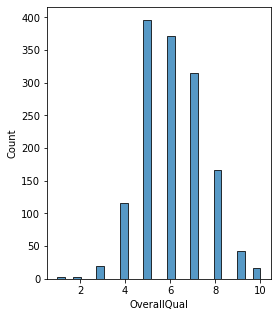

In [25]:
plt.figure(figsize=(4, 5))
sns.histplot(dados['OverallQual'])

C:\Users\013756631\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GrLivArea', ylabel='Density'>

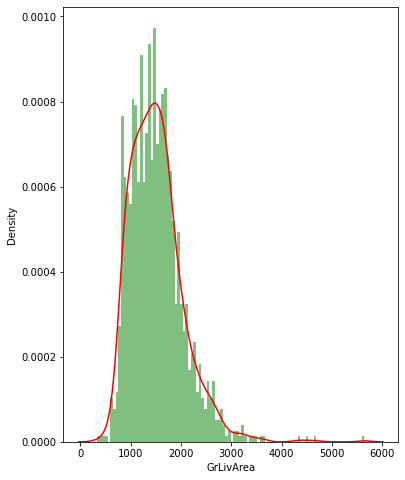

In [26]:
plt.figure(figsize=(6, 8))
sns.distplot(dados['GrLivArea'], 
             bins=100, 
             hist_kws={'alpha': 0.5,
                       'color': 'g'},
             kde_kws={"color": "red"})

<AxesSubplot:xlabel='ExterQual', ylabel='Count'>

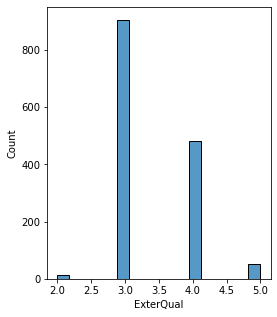

In [27]:
plt.figure(figsize=(4, 5))
sns.histplot(dados['ExterQual'])

<AxesSubplot:xlabel='KitchenQual', ylabel='Count'>

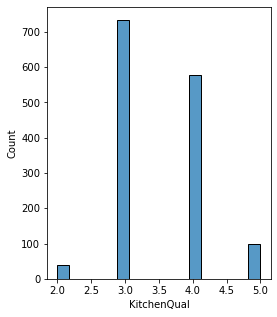

In [28]:
plt.figure(figsize=(4, 5))
sns.histplot(dados['KitchenQual'])

<AxesSubplot:xlabel='GarageCars', ylabel='Count'>

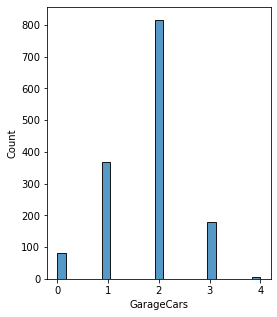

In [29]:
plt.figure(figsize=(4, 5))
sns.histplot(dados['GarageCars'])

C:\Users\013756631\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GarageArea', ylabel='Density'>

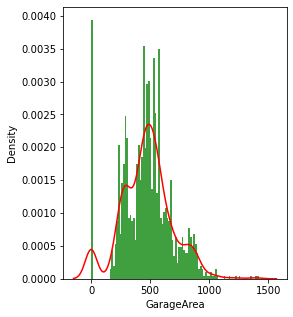

In [30]:
plt.figure(figsize=(4, 5))
sns.distplot(dados['GarageArea'], 
             bins=100, 
             hist_kws={'alpha': 0.75,
                       'color': 'g'},
             kde_kws={"color": "red"})

C:\Users\013756631\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TotalBsmtSF', ylabel='Density'>

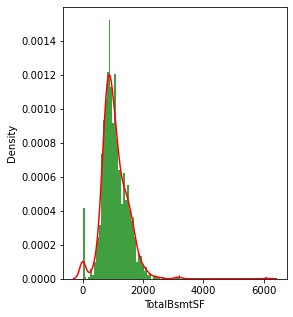

In [31]:
plt.figure(figsize=(4, 5))
sns.distplot(dados['TotalBsmtSF'], 
             bins=100, 
             hist_kws={'alpha': 0.75,
                       'color': 'g'},
             kde_kws={"color": "red"})

C:\Users\013756631\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='1stFlrSF', ylabel='Density'>

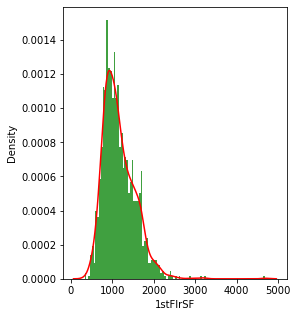

In [32]:
plt.figure(figsize=(4, 5))
sns.distplot(dados['1stFlrSF'], 
             bins=100, 
             hist_kws={'alpha': 0.75,
                       'color': 'g'},
             kde_kws={"color": "red"})

Todas as variáveis aparentam obter uma distribuição próxima da normal, com excessão das relacionadas da garagem que possuem uma inflação no número 0, relacionadas às transformações realizadas nos tratamento dos dados.

### Análise multivariada

A partir dos resultados de correlação obtidos acima, podemos fazer um estudo multivariado, visando não só verificar se há correlação, mas também analisar graficamente essa relação entre as variáveis.

<AxesSubplot:title={'center':'Área x Preço'}, xlabel='SalePrice', ylabel='GrLivArea'>

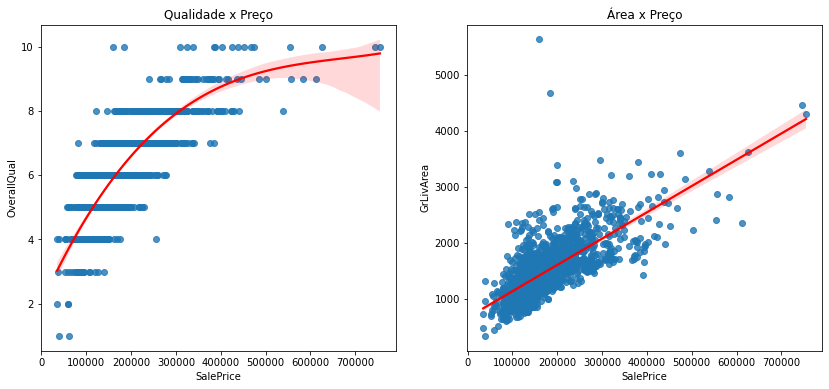

In [33]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6)) 

ax1.set_title('Qualidade x Preço')
sns.regplot(x='SalePrice', y='OverallQual', data=dados, ax=ax1, line_kws={"color": "red"}, order = 3)

ax2.set_title('Área x Preço')
sns.regplot(x='SalePrice', y='GrLivArea', data=dados, ax=ax2, line_kws={"color": "red"})

<AxesSubplot:title={'center':'Area da Garagem x Preço'}, xlabel='SalePrice', ylabel='KitchenQual'>

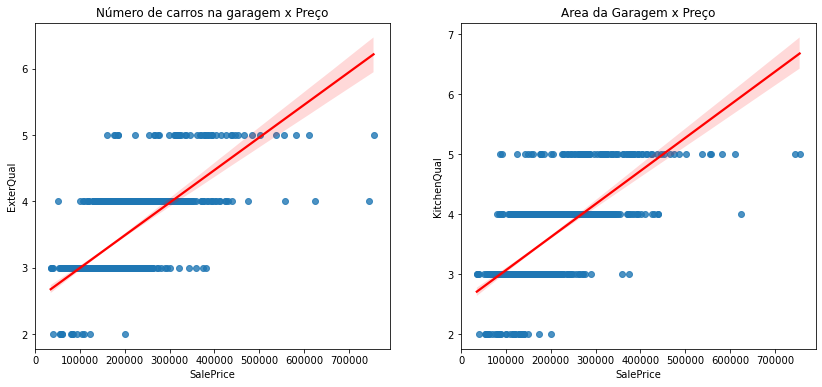

In [34]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6)) 

ax1.set_title('Número de carros na garagem x Preço')
sns.regplot(x='SalePrice', y='ExterQual', data=dados, ax=ax1, line_kws={"color": "red"})

ax2.set_title('Area da Garagem x Preço')
sns.regplot(x='SalePrice', y='KitchenQual', data=dados, ax=ax2, line_kws={"color": "red"})

<AxesSubplot:title={'center':'Area da Garagem x Preço'}, xlabel='SalePrice', ylabel='GarageArea'>

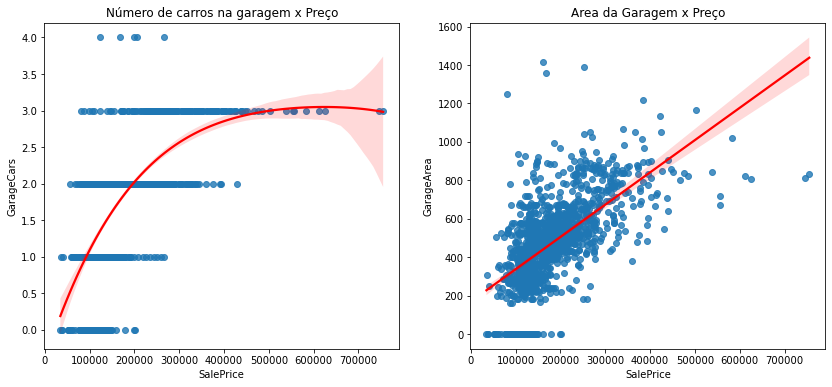

In [35]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6)) 

ax1.set_title('Número de carros na garagem x Preço')
sns.regplot(x='SalePrice', y='GarageCars', data=dados, ax=ax1, line_kws={"color": "red"}, order = 4)

ax2.set_title('Area da Garagem x Preço')
sns.regplot(x='SalePrice', y='GarageArea', data=dados, ax=ax2, line_kws={"color": "red"})


<AxesSubplot:title={'center':'Área x Preço'}, xlabel='SalePrice', ylabel='1stFlrSF'>

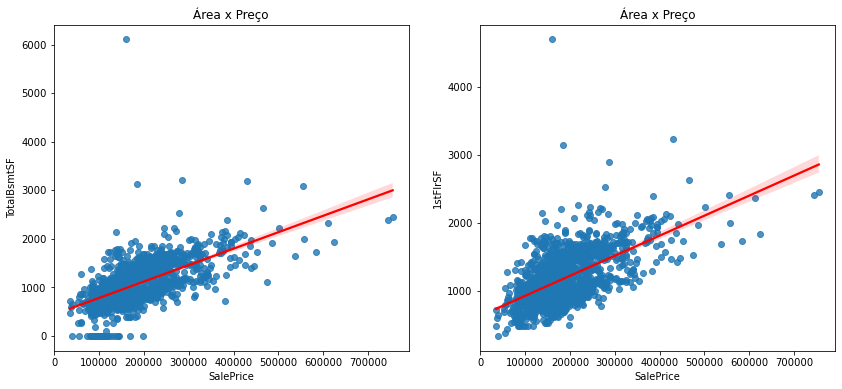

In [36]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6)) 

ax1.set_title('Área x Preço')
sns.regplot(x='SalePrice', y='TotalBsmtSF', data=dados, ax=ax1, line_kws={"color": "red"})

ax2.set_title('Área x Preço')
sns.regplot(x='SalePrice', y='1stFlrSF', data=dados, ax=ax2, line_kws={"color": "red"})

Alguns *outilers* presentes acima aparentar ser pontos de influência, o que causa uma mudança indesejada na curva da regressão. Vamos estudar essa influência mais a fundo posteriormente. 

Vamos também analisar graficamente as variáveis categóricas, ja que estas não possuem um consenso quanto ao cálculo do impacto delas na variável resposta.

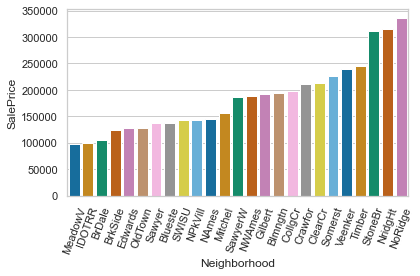

In [37]:
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")
result = dados.groupby(["Neighborhood"])['SalePrice'].aggregate(np.mean).reset_index().sort_values('SalePrice')
sns.barplot(x="Neighborhood", 
            y="SalePrice",
            data = dados,
            palette = "colorblind",
            ci = None,
            order=result['Neighborhood'])

plt.xticks(rotation=70)
plt.tight_layout()

PARECE HAVER DIFERENÇA ENTRE AS VIZINHANÇAS

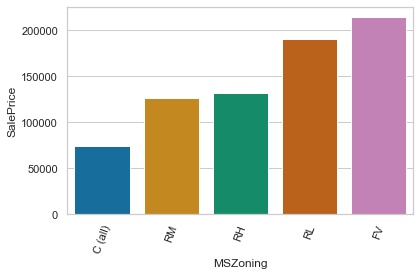

In [38]:
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")
result = dados.groupby(["MSZoning"])['SalePrice'].aggregate(np.mean).reset_index().sort_values('SalePrice')
sns.barplot(x="MSZoning", 
            y="SalePrice",
            data = dados,
            palette = "colorblind",
            ci = None,
            order=result['MSZoning'])

plt.xticks(rotation=70)
plt.tight_layout()

INTERPRETAR 

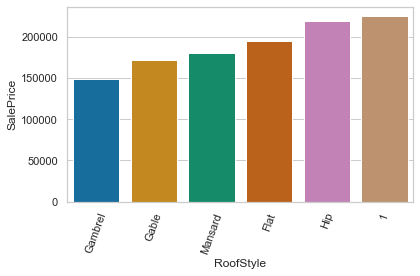

In [39]:
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")
result = dados.groupby(["RoofStyle"])['SalePrice'].aggregate(np.mean).reset_index().sort_values('SalePrice')
sns.barplot(x="RoofStyle", 
            y="SalePrice",
            data = dados,
            palette = "colorblind",
            ci = None,
            order=result['RoofStyle'])

plt.xticks(rotation=70)
plt.tight_layout()

INTERPRETAR / CORRIGIR ('SHED') 

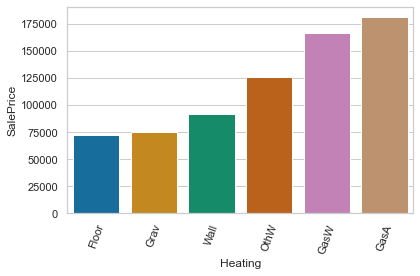

In [40]:
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")
result = dados.groupby(["Heating"])['SalePrice'].aggregate(np.mean).reset_index().sort_values('SalePrice')
sns.barplot(x="Heating", 
            y="SalePrice",
            data = dados,
            palette = "colorblind",
            ci = None,
            order=result['Heating'])

plt.xticks(rotation=70)
plt.tight_layout()

INTERPRETAR  

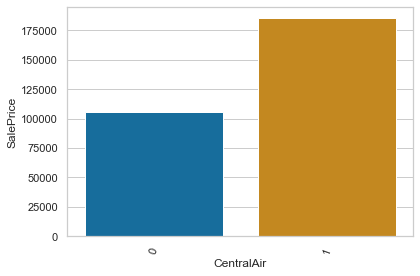

In [41]:
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")
result = dados.groupby(["CentralAir"])['SalePrice'].aggregate(np.mean).reset_index().sort_values('SalePrice')
sns.barplot(x="CentralAir", 
            y="SalePrice",
            data = dados,
            palette = "colorblind",
            ci = None,
            order=result['CentralAir'])

plt.xticks(rotation=70)
plt.tight_layout()

INTERPRETAR

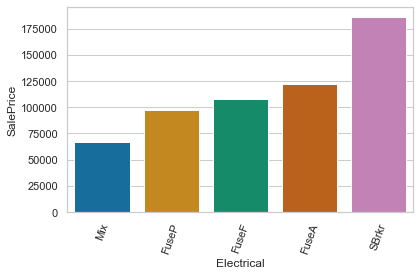

In [42]:
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")
result = dados.groupby(["Electrical"])['SalePrice'].aggregate(np.mean).reset_index().sort_values('SalePrice')
sns.barplot(x="Electrical", 
            y="SalePrice",
            data = dados,
            palette = "colorblind",
            ci = None,
            order=result['Electrical'])

plt.xticks(rotation=70)
plt.tight_layout()

INTERPRETAR

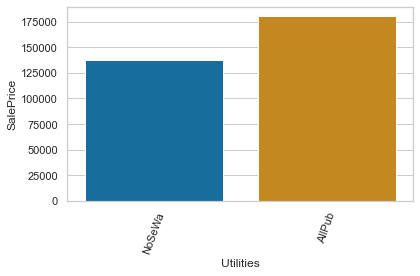

In [43]:
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")
result = dados.groupby(["Utilities"])['SalePrice'].aggregate(np.mean).reset_index().sort_values('SalePrice')
sns.barplot(x="Utilities", 
            y="SalePrice",
            data = dados,
            palette = "colorblind",
            ci = None,
            order=result['Utilities'])

plt.xticks(rotation=70)
plt.tight_layout()

INTERPRETAR

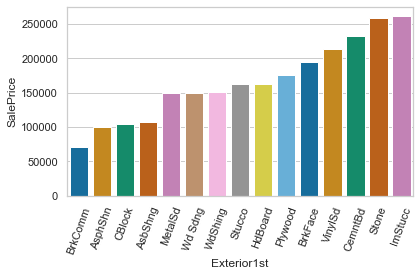

In [44]:
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")
result = dados.groupby(["Exterior1st"])['SalePrice'].aggregate(np.mean).reset_index().sort_values('SalePrice')
sns.barplot(x="Exterior1st", 
            y="SalePrice",
            data = dados,
            palette = "colorblind",
            ci = None,
            order=result['Exterior1st'])

plt.xticks(rotation=70)
plt.tight_layout()

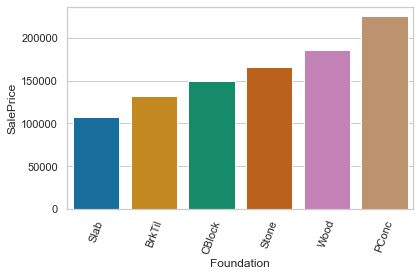

In [45]:
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")
result = dados.groupby(["Foundation"])['SalePrice'].aggregate(np.mean).reset_index().sort_values('SalePrice')
sns.barplot(x="Foundation", 
            y="SalePrice",
            data = dados,
            palette = "colorblind",
            ci = None,
            order=result['Foundation'])

plt.xticks(rotation=70)
plt.tight_layout()

### Análise e tratamento de pontos de influência

Como foi observado nas figuras acima, alguns pontos individuais parecem interferir consideravelmente na curva de regressão, assim podendo interferir também no ajuste de futuros modelos. Vamos realizar testes gráficos e estatísticos para atestar essa suposição, e, caso ela se confirme, tratarei da melhor maneira possível estes pontos.

Para isso, vamos criar um modelo de regressão simples, utilizando as covariáveis de maior correlação com a variável resposta, para ajustar um modelo encima de nossos dados e utilizar a distancia de cook para averiguar esta influência sobre o modelo.

In [46]:
# definindo a variável resposta

y = dados['SalePrice']

#define explanatory variable
x = dados[['OverallQual',
          'GrLivArea',
           "ExterQual",
           "KitchenQual",
          'GarageCars',
          'GarageArea',
          'TotalBsmtSF',
           '1stFlrSF']]

In [47]:
# Ajustando um modelo de regressão simples
modelo = sm.OLS(y, sm.add_constant(x)).fit() 
modelo.summary()

C:\Users\013756631\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     644.7
Date:                Fri, 04 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:12:03   Log-Likelihood:                -17324.
No. Observations:                1451   AIC:                         3.467e+04
Df Residuals:                    1442   BIC:                         3.471e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.507e+05   6427.875    -23.446      0.000   -1.63e+05   -1.38e+05
OverallQual  1.596e+04   1255.131     12.719      0.000    1.35e+04    1.84e+04
GrLivArea      43.9604      2.573     17.082      0.000      38.912      49.009
ExterQual    1.593e+04   2794.363      5.699      0.000    1.04e+04    2.14e+04
KitchenQual  1.463e+04   2244.161      6.517      0.000    1.02e+04     1.9e+04
GarageCars   1.195e+04   2903.396      4.116      0.000    6254.181    1.76e+04
GarageArea     10.9202     10.053      1.086      0.278      -8.799      30.639
TotalBsmtSF    20.2390      4.158      4.868      0.000      12.083      28.395
1stFlrSF       12.5043      4.841      2.583      0.010       3.008      22.001
==============================================================================
Omnibus:                      479.130   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54046.782
Skew:                          -0.467   Prob(JB):                         0.00
Kurtosis:                      32.884   Cond. No.                     1.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
np.set_printoptions(suppress=True)

#create instance of influence
influence = modelo.get_influence()

#obtain Cook's distance for each observation
cooks = influence.cooks_distance

#display Cook's distances
cooks

(array([0.000015  , 0.00008755, 0.00000031, ..., 0.00018413, 0.00003759,
        0.00000016]),
 array([1., 1., 1., ..., 1., 1., 1.]))

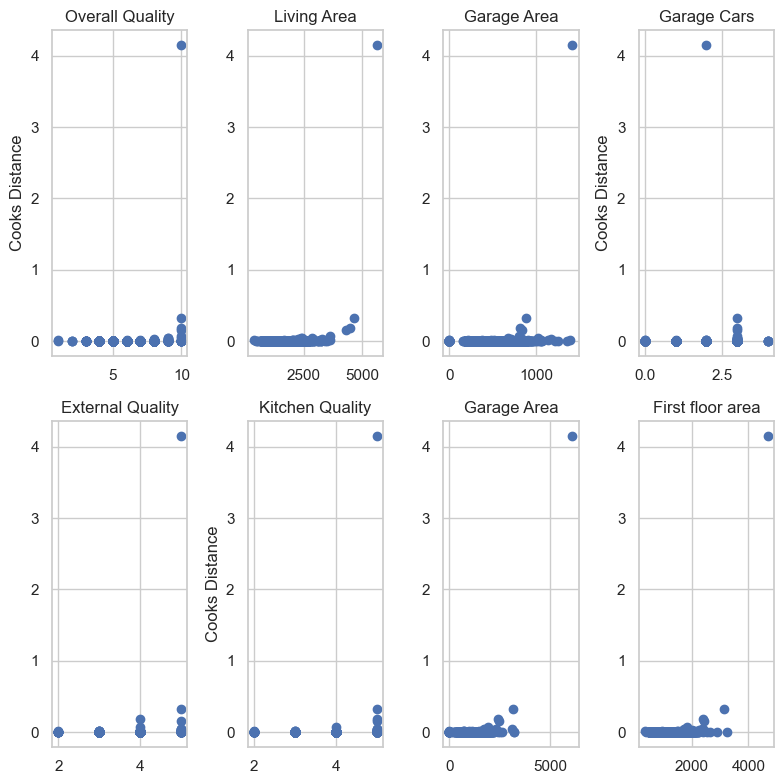

In [49]:
from matplotlib.pyplot import figure

figure(figsize=(8, 8), dpi=100)

plt.subplot(2, 4, 1)
plt.scatter(x['OverallQual'], cooks[0])
plt.title('Overall Quality')

plt.ylabel('Cooks Distance')

plt.subplot(2, 4, 2)
plt.scatter(x['GrLivArea'], cooks[0])
plt.title('Living Area')

plt.subplot(2, 4, 3)
plt.scatter(x['GarageArea'], cooks[0])
plt.title('Garage Area')


plt.subplot(2, 4, 4)
plt.scatter(x['GarageCars'], cooks[0])
plt.title('Garage Cars')
plt.ylabel('Cooks Distance')

plt.subplot(2, 4, 5)
plt.scatter(x['ExterQual'], cooks[0])
plt.title('External Quality')


plt.subplot(2, 4, 6)
plt.scatter(x['KitchenQual'], cooks[0])
plt.title('Kitchen Quality')
plt.ylabel('Cooks Distance')


plt.subplot(2, 4, 7)
plt.scatter(x['TotalBsmtSF'], cooks[0])
plt.title('Garage Area')

plt.subplot(2, 4, 8)
plt.scatter(x['1stFlrSF'], cooks[0])
plt.title('First floor area')

plt.tight_layout()
plt.show()

Podemos perceber que aparentemente poucos ou até mesmo um único ponto realiza uma influencia imensa em nosso modelo. Vamos observar quais são as consequências de deleta-lo. 

In [50]:
# Criando um dataframe copiado para não comprometer o original
copia = dados.copy()

# deletando baseado na observação presente no gráfico de 'First Floor Area' 
copia = copia.drop(copia[(copia['1stFlrSF'] > 4000) | 
                         (copia['GrLivArea'] > 4200)].index)



Agora, depois de excluir essa observação, vamos repetir o processo e analisar se houve uma melhora no modelo.

In [51]:
# definindo a variável resposta

y = copia['SalePrice']

#define explanatory variable
x = copia[['OverallQual',
          'GrLivArea',
          'GarageCars',
          'ExterQual',
          'KitchenQual',
          'GarageArea',
          'TotalBsmtSF',
           '1stFlrSF']]

# Ajustando um modelo de regressão simples
modelo = sm.OLS(y, sm.add_constant(x)).fit() 
modelo.summary()

C:\Users\013756631\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     860.8
Date:                Fri, 04 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:12:04   Log-Likelihood:                -17055.
No. Observations:                1447   AIC:                         3.413e+04
Df Residuals:                    1438   BIC:                         3.417e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.549e+05   5557.243    -27.870      0.000   -1.66e+05   -1.44e+05
OverallQual  1.415e+04   1082.752     13.067      0.000     1.2e+04    1.63e+04
GrLivArea      48.9061      2.296     21.300      0.000      44.402      53.410
GarageCars   3550.0443   2542.982      1.396      0.163   -1438.308    8538.396
ExterQual     1.74e+04   2402.272      7.244      0.000    1.27e+04    2.21e+04
KitchenQual  1.352e+04   1926.855      7.018      0.000    9743.037    1.73e+04
GarageArea     34.2026      8.737      3.915      0.000      17.063      51.342
TotalBsmtSF    33.7327      3.678      9.171      0.000      26.517      40.948
1stFlrSF        9.4564      4.165      2.270      0.023       1.286      17.627
==============================================================================
Omnibus:                      378.517   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2854.319
Skew:                           1.007   Prob(JB):                         0.00
Kurtosis:                       9.579   Cond. No.                     1.57e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 800x600 with 0 Axes>

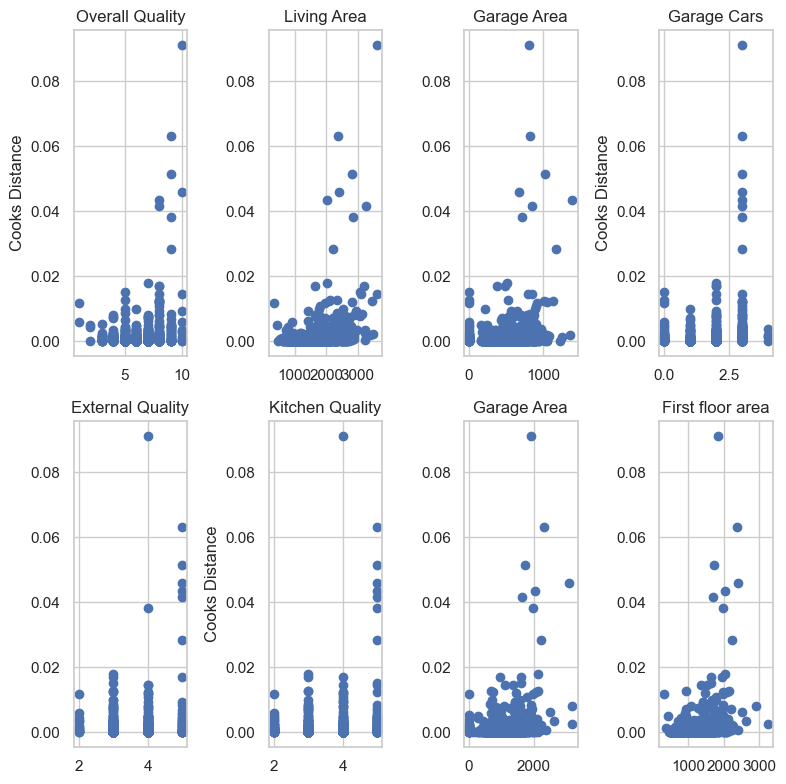

In [52]:
np.set_printoptions(suppress=True)

#create instance of influence
influence = modelo.get_influence()

#obtain Cook's distance for each observation
cooks = influence.cooks_distance

figure(figsize=(8, 6), dpi=100)

figure(figsize=(8, 8), dpi=100)

plt.subplot(2, 4, 1)
plt.scatter(x['OverallQual'], cooks[0])
plt.title('Overall Quality')

plt.ylabel('Cooks Distance')

plt.subplot(2, 4, 2)
plt.scatter(x['GrLivArea'], cooks[0])
plt.title('Living Area')

plt.subplot(2, 4, 3)
plt.scatter(x['GarageArea'], cooks[0])
plt.title('Garage Area')


plt.subplot(2, 4, 4)
plt.scatter(x['GarageCars'], cooks[0])
plt.title('Garage Cars')
plt.ylabel('Cooks Distance')

plt.subplot(2, 4, 5)
plt.scatter(x['ExterQual'], cooks[0])
plt.title('External Quality')


plt.subplot(2, 4, 6)
plt.scatter(x['KitchenQual'], cooks[0])
plt.title('Kitchen Quality')
plt.ylabel('Cooks Distance')


plt.subplot(2, 4, 7)
plt.scatter(x['TotalBsmtSF'], cooks[0])
plt.title('Garage Area')

plt.subplot(2, 4, 8)
plt.scatter(x['1stFlrSF'], cooks[0])
plt.title('First floor area')

plt.tight_layout()
plt.show()

É notável a diminuição no AIC e BIC após a remoção dos outliers em comparação com o modelo original. Podemos perceber também que a influência dos pontos pela distância de Cook está muito melhor distribuida. Vamos observar esse efeito graficamente na curva de regressão.

<AxesSubplot:title={'center':'Área x Preço'}, xlabel='SalePrice', ylabel='GrLivArea'>

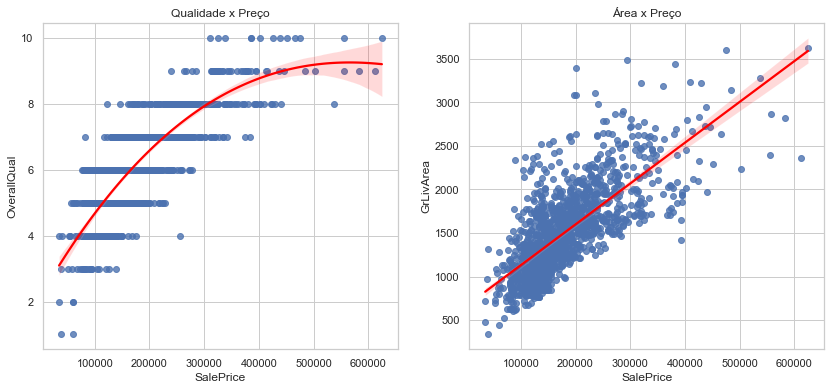

In [53]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6)) 

ax1.set_title('Qualidade x Preço')
sns.regplot(x='SalePrice', y='OverallQual', data=copia, ax=ax1, line_kws={"color": "red"}, order = 3)

ax2.set_title('Área x Preço')
sns.regplot(x='SalePrice', y='GrLivArea', data=copia, ax=ax2, line_kws={"color": "red"})

<AxesSubplot:title={'center':'Area da Garagem x Preço'}, xlabel='SalePrice', ylabel='GarageArea'>

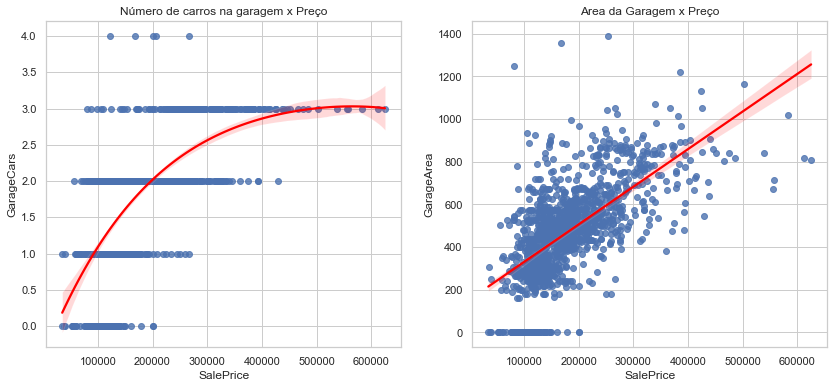

In [54]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6)) 

ax1.set_title('Número de carros na garagem x Preço')
sns.regplot(x='SalePrice', y='GarageCars', data=copia, ax=ax1, line_kws={"color": "red"}, order = 4)

ax2.set_title('Area da Garagem x Preço')
sns.regplot(x='SalePrice', y='GarageArea', data=copia, ax=ax2, line_kws={"color": "red"})


<AxesSubplot:title={'center':'Área do térreo'}, xlabel='SalePrice', ylabel='1stFlrSF'>

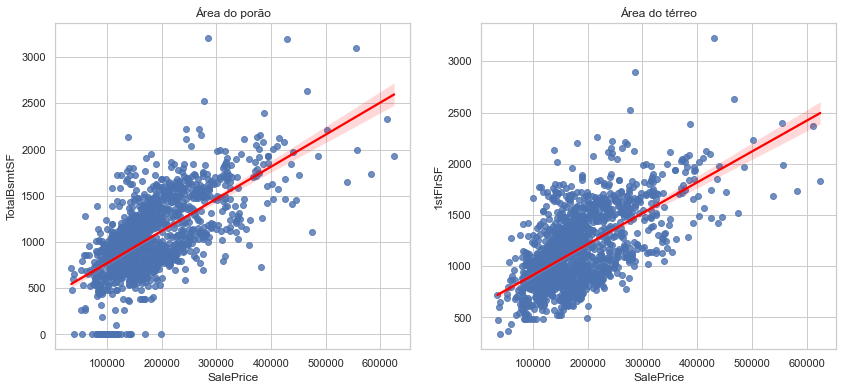

In [55]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6)) 

ax1.set_title('Área do porão')
sns.regplot(x='SalePrice', y='TotalBsmtSF', data=copia, ax=ax1, line_kws={"color": "red"})

ax2.set_title('Área do térreo')
sns.regplot(x='SalePrice', y='1stFlrSF', data=copia, ax=ax2, line_kws={"color": "red"})

Dadas as atuais melhorias do banco de dados 'copia' após a remoção de pontos de influência extremos em comparação com o banco de dados original, podemos passar a tratar-lo como o original

In [56]:
dados = copia
dados

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,1,0,Reg,Lvl,AllPub,Inside,...,0,0,0.0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,1,0,Reg,Lvl,AllPub,FR2,...,0,0,0.0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,1,0,IR1,Lvl,AllPub,Inside,...,0,0,0.0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,1,0,IR1,Lvl,AllPub,Corner,...,0,0,0.0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,1,0,IR1,Lvl,AllPub,FR2,...,0,0,0.0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,1,0,Reg,Lvl,AllPub,Inside,...,0,0,0.0,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,1,0,Reg,Lvl,AllPub,Inside,...,0,0,0.0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,1,0,Reg,Lvl,AllPub,Inside,...,0,0,0.0,1,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,1,0,Reg,Lvl,AllPub,Inside,...,0,0,0.0,0,0,4,2010,WD,Normal,142125


### Exportando os dados após tratamento

Vamos exportar os dados para utilizar outras ferramentas para realizar mais análises dos dados, além de realizar uma predição dos valores por meio de algoritmos de *Machine Learning* em Python.

In [57]:
dados.to_csv('.\dados_tratados.csv', index = False)